## 자연어 처리 과제입니다

파일명 제출 : nlp_{이름}.ipynb  
제출기한일 : 2023.10.10  
제출 이메일 : bluelemonsky7@gmail.com  
분석 대상 데이터 : 네이버 평점 test 데이터

평가 관점
1. 코드를 작성하여 error 없이 진행해야 함
2. 각종 모델을 비교하거나 선택한 이유 등을 작성
3. train : test 비율은 7:3으로 함
4. 최종 평가에서 train 데이터에 대한 정확도 90 이상, test 데이터에 대한 정확도는 85 이상을 목표로 함
5. 모델 평가에서 고정된 결과가 나오도록 하세요

Part 1 . 분석 환경에 대한 정보를 보여주세요

1. python 버전 
2. 주용 사용 패키지 버전 정보 


In [1]:
# 졍규 표현식 패키지
import re

# 토크나이저 패키지
from nltk.tokenize import word_tokenize
from ckonlpy.tag import Twitter
from konlpy.tag import Kkma

from tokenizers import Tokenizer
from nltk.tokenize import RegexpTokenizer

# 벡터화 패키지
from sklearn.feature_extraction.text import TfidfVectorizer

# 분류 모델 패키지
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier

!pip install xgboost
from xgboost import XGBClassifier

# 분류 모델 평가
from sklearn.metrics import classification_report

# 데이터 핸들링
import numpy as np
import pandas as pd

# 기타
from tqdm import tqdm # 분석 속도, 시간 확인, 정도 확인

Defaulting to user installation because normal site-packages is not writeable


In [2]:
from konlpy.tag import Okt

In [3]:
import tensorflow as tf
tf.__version__

'2.13.0'

In [4]:
import transformers
transformers.__version__

'4.34.0'

Part 2. 분석 데이터를 로드하세요

1. 판다스로 데이터를 read 하세요

In [5]:
# 데이터 로드
test_df = pd.read_csv('./data/ratings_test.csv')
test_df.dropna(inplace=True)

In [6]:
test_df.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [7]:
test_df.shape

(49997, 3)

In [8]:
# 데이터 전처리
# 한글만 남기기
test_df['document'] = test_df['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣]", " ")

C:\Users\leah5\AppData\Local\Temp\ipykernel_3180\19351791.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  test_df['document'] = test_df['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣]", " ")


In [9]:
test_df

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,,0
2,8544678,뭐야 이 평점들은 나쁘진 않지만 점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임 돈주고 보기에는,0
4,6723715,만 아니었어도 별 다섯 개 줬을텐데 왜 로 나와서 제 심기를 불편하게 하죠,0
...,...,...,...
49995,4608761,오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1
49996,5308387,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따,0
49997,9072549,그림도 좋고 완성도도 높았지만 보는 내내 불안하게 만든다,0
49998,5802125,절대 봐서는 안 될 영화 재미도 없고 기분만 잡치고 한 세트장에서 다 해먹네,0


In [10]:
# 영어를 지우고 나오는 공백 제거
test_df['document'].replace('                    ', np.nan, inplace=True)

In [11]:
test_df

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,NaN,0
2,8544678,뭐야 이 평점들은 나쁘진 않지만 점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임 돈주고 보기에는,0
4,6723715,만 아니었어도 별 다섯 개 줬을텐데 왜 로 나와서 제 심기를 불편하게 하죠,0
...,...,...,...
49995,4608761,오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1
49996,5308387,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따,0
49997,9072549,그림도 좋고 완성도도 높았지만 보는 내내 불안하게 만든다,0
49998,5802125,절대 봐서는 안 될 영화 재미도 없고 기분만 잡치고 한 세트장에서 다 해먹네,0


In [12]:
# 3개의 nan값이 있음
test_df.loc[test_df.document.isnull()].sum()

id          34365544
document           0
label              3
dtype: object

In [13]:
# nan값 제거
test_df = test_df.dropna(how = 'any')
print(len(test_df))

49993


In [16]:
# 7:3으로 데이터 분리
X_train, y_train = test_df['document'][:34995], test_df['label'][:34995]
X_test, y_test = test_df['document'][34995:] , test_df['label'][34995:]

In [17]:
X_train.shape , X_test.shape

((34995,), (14998,))

Part 3. 텍스트 데이터를 EDA하세요

1. 통계적으로 텍스트를 확인해 보세요
2. 시각화 해보세요
3. 불용어(stop words)를 찾아보세요
4. 기타 여러 방법으로 EDA를 해보세요

In [18]:
test_df.head()

,id,document,label
0,6270596,굳 ㅋ,1
2,8544678,뭐야 이 평점들은 나쁘진 않지만 점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임 돈주고 보기에는,0
4,6723715,만 아니었어도 별 다섯 개 줬을텐데 왜 로 나와서 제 심기를 불편하게 하죠,0
5,7898805,음악이 주가 된 최고의 음악영화,1


In [20]:
# 불용어 정의
stopwords = ['의', '가', '이', '은', '들', '는', '좀', '을', '를', '는', '으로', '에', '와', '과','이', '것', '그','잘','좀','것','점','내','한','하다']

In [21]:
# 토크나이저에 불용어 적용

okt = Okt()

tokenized_words , sentence_nouns = [] , []

for sentence in test_df['document'] :
    # 형태소 분석 토큰화
    tokenized_word = okt.morphs(sentence, stem=True) # 토큰화 및 정규화
    stopwords_removed_sentence = [word for word in tokenized_word if not word in stopwords]
    tokenized_words.append(stopwords_removed_sentence)

    # 명사만 추출
    nouns = okt.nouns(sentence)
    sentence_nouns.append(nouns)

In [22]:
# 리뷰의 최대 길이
word_len = [len(l) for l in tokenized_words]
nouns_len = [len(l) for l in sentence_nouns]

print(f"가장 긴 단어 길이 : {max(word_len)} || 가장 짧은 단어 길이 : {min(word_len)}")
print(f"가장 긴 명사 길이 : {max(nouns_len)} || 가장 짧은 명사 길이 : {min(nouns_len)}")


가장 긴 단어 길이 : 63 || 가장 짧은 단어 길이 : 0
가장 긴 명사 길이 : 39 || 가장 짧은 명사 길이 : 0


In [23]:
# 데이터에서 추출된 품사 보기
pos_dict = {}
for tag in okt.tagset.keys():
    pos_dict[tag] = 0

print(pos_dict)

for doc in test_df['document']:
    doc_pos = okt.pos(str(doc))
    for uni_pos in doc_pos:
        if uni_pos[1] in pos_dict.keys():
            pos_dict[uni_pos[1]] = pos_dict[uni_pos[1]] + 1
        else:
            pos_dict[uni_pos[1]] = 1

print(pos_dict)

{'Adjective': 0, 'Adverb': 0, 'Alpha': 0, 'Conjunction': 0, 'Determiner': 0, 'Eomi': 0, 'Exclamation': 0, 'Foreign': 0, 'Hashtag': 0, 'Josa': 0, 'KoreanParticle': 0, 'Noun': 0, 'Number': 0, 'PreEomi': 0, 'Punctuation': 0, 'ScreenName': 0, 'Suffix': 0, 'Unknown': 0, 'Verb': 0}
{'Adjective': 63484, 'Adverb': 14923, 'Alpha': 0, 'Conjunction': 1342, 'Determiner': 5899, 'Eomi': 173, 'Exclamation': 2075, 'Foreign': 0, 'Hashtag': 0, 'Josa': 122113, 'KoreanParticle': 8992, 'Noun': 302912, 'Number': 0, 'PreEomi': 10, 'Punctuation': 0, 'ScreenName': 0, 'Suffix': 15575, 'Unknown': 0, 'Verb': 89369, 'Modifier': 11136, 'VerbPrefix': 3671}


<Axes: >

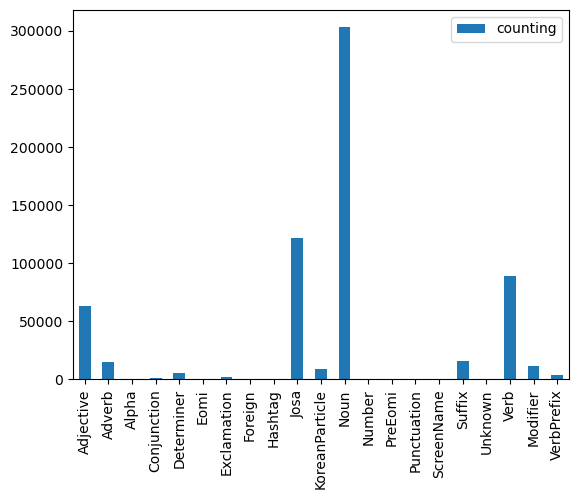

In [24]:
# 품사 빈도 시각화
# 명사가 가장 많은 빈도를 차지함
pd.DataFrame(pos_dict.values(), index=pos_dict.keys(), columns=['counting']).plot.bar()

In [25]:
!pip install wordcloud koreanize_matplotlib

Defaulting to user installation because normal site-packages is not writeable


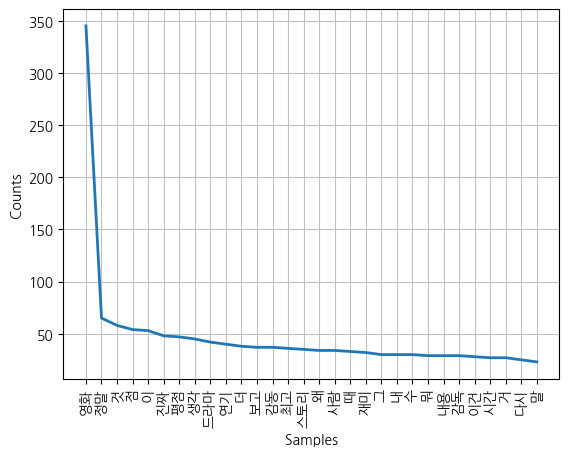

In [26]:
# 가장 많이 쓰인 명사 시각화
from nltk import Text
import matplotlib.pyplot as plt
import koreanize_matplotlib

all_reviews = ' '.join(test_df['document'][:1000].astype('str'))

review_nouns = Text(okt.nouns(all_reviews), name = "naver movie review")
review_nouns.plot(30)
plt.show()

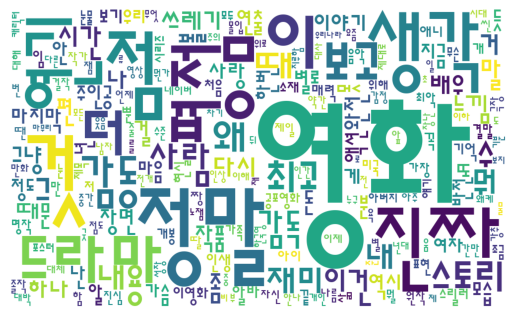

In [27]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

font_path = 'C:\\Windows\\Fonts\\H2SA1M.TTF'

wc = WordCloud(width=1000, height=600, background_color="white", font_path=font_path)
plt.imshow(wc.generate_from_frequencies(review_nouns.vocab()))
plt.axis("off")
plt.show()

Part 4. 텍스트 데이터를 임베딩 하세요

1. 텍스트 토크나이즈를 해보세요
2. 텍스트를 벡터화 하세요

In [28]:
class UserTokenizers :
    def __init__(self) -> None:
        self.okt = Twitter()
        self.kkma = Kkma()
        self.bpe_tokenizer_pretrained = Tokenizer.from_file('./tokenizer_data/bpe_tokenizer.json')

    @staticmethod
    def whitespaceToken(data : str) -> list :
        token_rs = data.split(' ')
        return token_rs

    @staticmethod
    def regexsplitToken(data : str , pat : str = '[\,\.!?\n]') -> list :
        re_rs = re.split(pat, data , maxsplit= 0)
        token_rs = [rs_unit.strip() for rs_unit in re_rs if len(rs_unit.strip()) > 1]
        return token_rs

    @staticmethod
    def regexselectToken(data : str , pat : str = '[\w]+') -> list :
        token_rs = RegexpTokenizer(pat).tokenize(data)
        return token_rs

    def BPETokenizer(self, data : str ) -> list :
        token_rs = self.bpe_tokenizer_pretrained.encode(data).tokens
        return token_rs

    #한글과 영어를 같이 사용
    def tokenizingKorEng(self, data :str ) -> list :
        kor_re = re.findall('[ㄱ-ㅎ|ㅏ-ㅣ|가-힣]+', data)
        kor_str = ' '.join(kor_re)

        eng_re = re.findall('[a-zA-Z]+', data)
        eng_str = ' '.join(eng_re)

        kor_rs = self.okt.morphs(kor_str)
        eng_rs = word_tokenize(eng_str)

        token_rs = kor_rs + eng_rs

        return token_rs

    def konlpyNounsTokenizer(self, data:str) -> list :
        token_rs = self.kkma.nouns(data)
        return token_rs


In [29]:
ut_cls = UserTokenizers()

c:\ProgramData\anaconda3\lib\site-packages\konlpy\tag\_okt.py:17: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


In [30]:
# 사용자 토크나이저 적용 확인
X_train[7]

'마치 미국애니에서 튀어나온듯한 창의력없는 로봇디자인부터가 고개를 젖게한다'

In [31]:
ut_cls.tokenizingKorEng(X_train[7])

['마치',
 '미국',
 '애니',
 '에서',
 '튀어',
 '나',
 '온',
 '듯',
 '한',
 '창의력',
 '없는',
 '로봇',
 '디자인',
 '부터가',
 '고개',
 '를',
 '젖게',
 '한다']

In [32]:
ut_cls.konlpyNounsTokenizer(X_train[7])

['미국', '미국애', '애', '창의력', '로봇', '로봇디자인', '디자인', '고개']

In [33]:
ut_cls.BPETokenizer(X_train[7])

['마치</w>',
 '미국',
 '애니',
 '에서</w>',
 '튀',
 '어',
 '나온',
 '듯한</w>',
 '창의',
 '력',
 '없는</w>',
 '로봇',
 '디자',
 '인',
 '부터가</w>',
 '고',
 '개를</w>',
 '게',
 '한다</w>']

In [34]:
# 불용어 사전 불러오기
print(stopwords)

['의', '가', '이', '은', '들', '는', '좀', '을', '를', '는', '으로', '에', '와', '과', '이', '것', '그', '잘', '좀', '것', '점', '내', '한', '하다']


In [35]:
# 벡터화 하기
tfidf_vect = TfidfVectorizer(tokenizer=ut_cls.BPETokenizer , stop_words=stopwords)

In [36]:
tfidf_vect.fit(X_train)

c:\ProgramData\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\ProgramData\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['가</w>', '것</w>', '과</w>', '그</w>', '내</w>', '는</w>', '들</w>', '를</w>', '에</w>', '와</w>', '으로</w>', '은</w>', '을</w>', '의</w>', '이</w>', '잘</w>', '점</w>', '좀</w>', '하다</w>', '한</w>'] not in stop_words.
  warnings.warn(


TfidfVectorizer(stop_words=['의', '가', '이', '은', '들', '는', '좀', '을', '를', '는',
                            '으로', '에', '와', '과', '이', '것', '그', '잘', '좀', '것',
                            '점', '내', '한', '하다'],
                tokenizer=<bound method UserTokenizers.BPETokenizer of <__main__.UserTokenizers object at 0x0000026C04248B20>>)

In [37]:
tfidf_vect.get_feature_names_out()

array(['ㄱ', 'ㄱ</w>', 'ㄱㄱ</w>', ..., '힘들었다</w>', '힘을</w>', '힘이</w>'],
      dtype=object)

In [38]:
class TransformVect :
    def __init__(self, vec_model) -> None:
        # 서비스로 개발을 한다면, 저장된 vec_model을 로딩하는 부분으로 변경
        self.vec_model = vec_model

    def transVect_run(self, chunk_size : int = 500 , data : pd.DataFrame = None ) -> np.array :

        data_len = len(data)

        for st_idx in tqdm(range(0, data_len, chunk_size)):
            tmp_data = data[st_idx:st_idx+chunk_size]

            if st_idx == 0:
                vec_arr = self.vec_model.transform(tmp_data).toarray()
                # print(f"num1 : {vec_arr.shape} || dim : {vec_arr.ndim}")

            else :
                tmp_data_arr = self.vec_model.transform(tmp_data).toarray()
                # print(f"num2 : {tmp_data_arr.shape} || dim : {tmp_data_arr.ndim}")

                vec_arr = np.concatenate([vec_arr, tmp_data_arr], 0)
                # print(f"num2 more : tmp_data_arr : {tmp_data_arr.shape} || vec_arr : {vec_arr.shape}")

        return vec_arr


In [39]:
tfv_cls = TransformVect(tfidf_vect)

In [40]:
y_train.sum() , y_train.count() , y_test.sum() , y_test.count()

(17666, 34995, 7502, 14998)

In [41]:
x_train = tfv_cls.transVect_run(chunk_size=100, data=X_train)

100%|██████████| 350/350 [01:46<00:00,  3.29it/s]


In [42]:
x_test = tfv_cls.transVect_run(chunk_size=100, data=X_test)

100%|██████████| 150/150 [00:20<00:00,  7.48it/s]


In [43]:
x_train.shape , x_test.shape

((34995, 9433), (14998, 9433))

Part 5. 분류 모델을 훈련하고 적용해 보세요

In [44]:
# 고정된 모델 결과
random_seed_num = 42

In [45]:
# 의사결정나무
clf_decision = DecisionTreeClassifier(random_state=random_seed_num, max_depth=5)
clf_decision.fit(x_train, y_train)

y_train_pred = clf_decision.predict(x_train)
y_test_pred = clf_decision.predict(x_test)

In [40]:
# 1번째 try => 전처리x, 토크나이저: BPETokenizer
print(classification_report(y_train, y_train_pred))
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.53      0.96      0.69     17330
           1       0.81      0.19      0.30     17670

    accuracy                           0.57     35000
   macro avg       0.67      0.57      0.49     35000
weighted avg       0.67      0.57      0.49     35000

              precision    recall  f1-score   support

           0       0.54      0.95      0.69      7496
           1       0.80      0.18      0.29      7501

    accuracy                           0.57     14997
   macro avg       0.67      0.57      0.49     14997
weighted avg       0.67      0.57      0.49     14997



In [46]:
# 2번째 try => 전처리ㅇ, 토크나이저: BPETokenizer
print(classification_report(y_train, y_train_pred))
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.95      0.06      0.11     17329
           1       0.52      1.00      0.68     17666

    accuracy                           0.53     34995
   macro avg       0.74      0.53      0.39     34995
weighted avg       0.73      0.53      0.40     34995

              precision    recall  f1-score   support

           0       0.92      0.05      0.10      7496
           1       0.51      1.00      0.68      7502

    accuracy                           0.53     14998
   macro avg       0.72      0.52      0.39     14998
weighted avg       0.72      0.53      0.39     14998



In [47]:
# randomforest

rfc_decision = RandomForestClassifier(random_state=random_seed_num, max_depth=5)
rfc_decision.fit(x_train, y_train)

y_train_pred = rfc_decision.predict(x_train)
y_test_pred = rfc_decision.predict(x_test)

In [42]:
# 1번째 try => 전처리x, 토크나이저: BPETokenizer
print(classification_report(y_train, y_train_pred))
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.82      0.48      0.61     17330
           1       0.64      0.90      0.75     17670

    accuracy                           0.69     35000
   macro avg       0.73      0.69      0.68     35000
weighted avg       0.73      0.69      0.68     35000

              precision    recall  f1-score   support

           0       0.81      0.47      0.59      7496
           1       0.62      0.89      0.73      7501

    accuracy                           0.68     14997
   macro avg       0.71      0.68      0.66     14997
weighted avg       0.71      0.68      0.66     14997



In [48]:
# 2번째 try => 전처리ㅇ, 토크나이저: BPETokenizer
print(classification_report(y_train, y_train_pred))
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.86      0.43      0.57     17329
           1       0.63      0.93      0.75     17666

    accuracy                           0.68     34995
   macro avg       0.74      0.68      0.66     34995
weighted avg       0.74      0.68      0.66     34995

              precision    recall  f1-score   support

           0       0.84      0.41      0.55      7496
           1       0.61      0.92      0.73      7502

    accuracy                           0.67     14998
   macro avg       0.72      0.67      0.64     14998
weighted avg       0.72      0.67      0.64     14998



In [49]:
# kneighbors

clf_kneighbors = KNeighborsClassifier(n_neighbors=3 , weights='distance', leaf_size=50)
clf_kneighbors.fit(x_train, y_train)

y_train_pred = clf_kneighbors.predict(x_train)
y_test_pred = clf_kneighbors.predict(x_test)

In [44]:
# 1번째 try => 전처리x, 토크나이저: BPETokenizer
print(classification_report(y_train, y_train_pred))
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17330
           1       1.00      1.00      1.00     17670

    accuracy                           1.00     35000
   macro avg       1.00      1.00      1.00     35000
weighted avg       1.00      1.00      1.00     35000

              precision    recall  f1-score   support

           0       0.53      0.97      0.68      7496
           1       0.80      0.14      0.23      7501

    accuracy                           0.55     14997
   macro avg       0.66      0.55      0.46     14997
weighted avg       0.66      0.55      0.46     14997



In [50]:
# 2번째 try => 전처리ㅇ, 토크나이저: BPETokenizer
print(classification_report(y_train, y_train_pred))
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     17329
           1       1.00      0.99      0.99     17666

    accuracy                           0.99     34995
   macro avg       0.99      0.99      0.99     34995
weighted avg       0.99      0.99      0.99     34995

              precision    recall  f1-score   support

           0       0.53      0.97      0.69      7496
           1       0.84      0.15      0.25      7502

    accuracy                           0.56     14998
   macro avg       0.69      0.56      0.47     14998
weighted avg       0.69      0.56      0.47     14998



In [51]:
# 로지스틱

clf_logistic = LogisticRegression(max_iter=3000, random_state=random_seed_num)
clf_logistic.fit(x_train, y_train)

y_train_pred = clf_logistic.predict(x_train)
y_test_pred = clf_logistic.predict(x_test)

In [46]:
# 1번째 try => 전처리x, 토크나이저: BPETokenizer
print(classification_report(y_train, y_train_pred))
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.88      0.89      0.88     17330
           1       0.89      0.88      0.88     17670

    accuracy                           0.88     35000
   macro avg       0.88      0.88      0.88     35000
weighted avg       0.88      0.88      0.88     35000

              precision    recall  f1-score   support

           0       0.82      0.83      0.82      7496
           1       0.83      0.82      0.82      7501

    accuracy                           0.82     14997
   macro avg       0.82      0.82      0.82     14997
weighted avg       0.82      0.82      0.82     14997



In [52]:
# 2번째 try => 전처리ㅇ, 토크나이저: BPETokenizer
print(classification_report(y_train, y_train_pred))
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.87      0.89      0.88     17329
           1       0.89      0.87      0.88     17666

    accuracy                           0.88     34995
   macro avg       0.88      0.88      0.88     34995
weighted avg       0.88      0.88      0.88     34995

              precision    recall  f1-score   support

           0       0.82      0.83      0.82      7496
           1       0.82      0.81      0.82      7502

    accuracy                           0.82     14998
   macro avg       0.82      0.82      0.82     14998
weighted avg       0.82      0.82      0.82     14998



In [53]:
# xgb
clf_xgb = XGBClassifier(random_state = random_seed_num, max_depth=5)
clf_xgb.fit(x_train, y_train)

y_train_pred = clf_xgb.predict(x_train)
y_test_pred = clf_xgb.predict(x_test)

In [109]:
# 1번째 try => 전처리x, 토크나이저: BPETokenizer
print(classification_report(y_train, y_train_pred))
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.72      0.85      0.78     17316
           1       0.83      0.68      0.75     17646

    accuracy                           0.77     34962
   macro avg       0.77      0.77      0.76     34962
weighted avg       0.77      0.77      0.76     34962

              precision    recall  f1-score   support

           0       0.70      0.82      0.75      7490
           1       0.78      0.65      0.71      7494

    accuracy                           0.73     14984
   macro avg       0.74      0.73      0.73     14984
weighted avg       0.74      0.73      0.73     14984



In [54]:
# 2번째 try => 전처리ㅇ, 토크나이저: BPETokenizer
print(classification_report(y_train, y_train_pred))
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.72      0.85      0.78     17329
           1       0.82      0.68      0.75     17666

    accuracy                           0.77     34995
   macro avg       0.77      0.77      0.76     34995
weighted avg       0.77      0.77      0.76     34995

              precision    recall  f1-score   support

           0       0.70      0.81      0.75      7496
           1       0.78      0.65      0.71      7502

    accuracy                           0.73     14998
   macro avg       0.74      0.73      0.73     14998
weighted avg       0.74      0.73      0.73     14998



In [55]:
# 앙상블 모델

# voting 방식
## soft : 각 모델의 결과가 특정 라벨이라고 하는 확률값을 사용하여 결과 도출
## hard : 각 모델의 최종 결과(라벨)에서 다수로 라벨링된 결과를 도출, 0 : 5개 , 1 : 1개 => 0인 라벨 / 보팅 모델의 세부 총수 : 6개

clf_ensemble = VotingClassifier(estimators=[('logistic', clf_logistic), ('kneighbors', clf_kneighbors), ('xgboost', clf_xgb)], voting = 'soft')
clf_ensemble.fit(x_train, y_train)

y_train_pred = clf_ensemble.predict(x_train)
y_test_pred = clf_ensemble.predict(x_test)

In [50]:
# 1번째 try => 전처리x, 토크나이저: BPETokenizer
print(classification_report(y_train, y_train_pred))
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     17330
           1       0.99      0.99      0.99     17670

    accuracy                           0.99     35000
   macro avg       0.99      0.99      0.99     35000
weighted avg       0.99      0.99      0.99     35000

              precision    recall  f1-score   support

           0       0.67      0.94      0.78      7496
           1       0.90      0.53      0.67      7501

    accuracy                           0.74     14997
   macro avg       0.78      0.74      0.72     14997
weighted avg       0.78      0.74      0.72     14997



In [56]:
# 2번째 try => 전처리ㅇ, 토크나이저: BPETokenizer
print(classification_report(y_train, y_train_pred))
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99     17329
           1       0.99      0.98      0.99     17666

    accuracy                           0.99     34995
   macro avg       0.99      0.99      0.99     34995
weighted avg       0.99      0.99      0.99     34995

              precision    recall  f1-score   support

           0       0.74      0.90      0.81      7496
           1       0.88      0.68      0.77      7502

    accuracy                           0.79     14998
   macro avg       0.81      0.79      0.79     14998
weighted avg       0.81      0.79      0.79     14998



Part 6. 모델을 평가하세요

<사용한 모델>   
- 의사결정나무    
- randomforest    
- kneighbors  
- 로지스틱    
- xgb 
- 앙상블 모델   


<비교 기준>
- 총 5가지 모델을 가지고 훈련을 실시했습니다. 
- 토큰화는 BPETokenizer으로 실시했습니다. 
- 첫번째 시도는 아무런 전처리(nan값만 제거)를 하지 않았고     
- 두번째 시도는 전처리를(특수문자,영어,nan 제거) 실시했습니다.        


<결과>
- 각각의 정확도는 다음과 같습니다.        

대체로 의사결정나무, randomforest, kneighbors는 전처리 전이 전처리 후보다 정확도가 높고,        
로지스틱, xgb는 전처리 전과 후의 정확도가 같습니다.     
그리고 앙상블 모델이 유일하게 전처리 후의 정확도가 전처리 전의 정확도보다 높습니다.     

그리고 train과 test의 정확도가 둘 다 비교적 높은 모델은     
- 1순위: 전처리 전,후 로지스틱 train = 88%, test = 82%        
- 2순위: 전처리 후 앙상블 모델 train = 99%, test = 79%        
- 3순위: 전처리 전,후 xgb train = 77%, test = 73%     입니다.

<아쉬운 점>
- 패딩과 같은 전처리를 시도해보고 딥러닝 모델을 이용하는 시도를 해보고 싶은 아쉬움이 있습니다.
- 데이터에 맞는 꼼꼼한 전처리가 중요함을 깨달았습니다.